In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import pyro
import pyro.distributions as dist
from pyro.infer.autoguide import AutoNormal, AutoMultivariateNormal, AutoDelta
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
from chirho.indexed.handlers import IndexPlatesMessenger
from chirho.counterfactual.handlers import MultiWorldCounterfactual
from chirho.indexed.ops import IndexSet, gather, indices_of
from chirho.interventional.handlers import do
from chirho.observational.handlers import condition


from cities.utils.data_grabber import (DataGrabber, list_available_features, list_tensed_features)
from cities.utils.cleaning_utils import check_if_tensed 

from pyro.infer import Predictive

In [33]:
def plot_predictive(model,T_outcome, N_states, state_index, time_index, intervention, guide=None):

    model = condition(data=dict(T_outcome = T_outcome, N_states = N_states, state_index = state_index,
                                time_index = time_index, intervention = intervention))(model)
    
    #if guide:
    #    guide_tr = pyro.poutine.trace(guide).get_trace()
    #    model_tr = pyro.poutine.trace(pyro.poutine.replay(model(T_outcome = T_outcome, N_states = N_states, state_index = state_index,
    #                            time_index = time_index, intervention = intervention), trace=guide_tr)).get_trace()
    #else:
    with pyro.poutine.trace() as tr:
        model(T_outcome = T_outcome, N_states = N_states, state_index = state_index,
                                time_index = time_index, intervention = intervention)

    model_tr = tr.trace
    y = model_tr.nodes['y']['value']

    predictive_copy = i_o_data.copy()

    predictive_copy['post_test'] = y.reshape(-1, 1).detach().numpy()  

    sns.pairplot(predictive_copy[[intervention_variable, f"{outcome_dataset}_shifted_by_{forward_shift}", 'post_test']])
    

In [34]:
list_tensed_features()

['industry_wholesale_trade_total',
 'industry_healthcare_social_services_total',
 'industry_public_administration_total',
 'unemployment_rate',
 'industry_utilities_total',
 'industry_agriculture_total',
 'industry_manufacturing_total',
 'spending_transportation',
 'industry_transportation_warehousing_total',
 'population',
 'industry_real_estate_total',
 'spending_commerce',
 'gdp',
 'industry_retail_trade_total',
 'industry_admin_support_services_total',
 'industry_accommodation_food_services_total',
 'industry_professional_services_total',
 'industry_information_total',
 'industry_other_services_total',
 'industry_finance_insurance_total',
 'industry_management_enterprises_total',
 'industry_arts_recreation_total',
 'industry_mining_total',
 'industry_construction_total',
 'spending_HHS',
 'industry_educational_services_total']

In [79]:
dg = DataGrabber()


outcome_dataset = 'unemployment_rate'
intervention_dataset = 'spending_commerce'
intervention_variable = 'total_obligated_amount'
forward_shift = 2

tensed_covariates_datasets = [var for var in list_tensed_features() if var not in [outcome_dataset, intervention_dataset]]
fixed_covariates_datasets = [var for var in list_available_features() if var not in tensed_covariates_datasets + [outcome_dataset, intervention_dataset]]

dg.get_features_std_long(list_available_features()) 
dg.get_features_std_wide(list_available_features()) 

year_min = max(dg.std_long[intervention_dataset]['Year'].min(), dg.std_long[outcome_dataset]['Year'].min())
year_max = min(dg.std_long[intervention_dataset]['Year'].max(), dg.std_long[outcome_dataset]['Year'].max())

outcome_df = dg.std_long[outcome_dataset].sort_values(by=['GeoFIPS', 'Year'])

outcome_df[f'{outcome_dataset}_shifted_by_{forward_shift}'] = None

geo_subsets = []
for geo_fips in outcome_df['GeoFIPS'].unique():
    geo_subset = outcome_df[outcome_df['GeoFIPS'] == geo_fips].copy()
    # Shift the 'Value' column `forward_shift` in a new column
    geo_subset[f'{outcome_dataset}_shifted_by_{forward_shift}'] = geo_subset['Value'].shift(-forward_shift)
    geo_subsets.append(geo_subset)
    
outcome_df = pd.concat(geo_subsets).reset_index(drop=True)

outcome = outcome_df[(outcome_df['Year'] >= year_min) & (outcome_df['Year'] <= year_max + forward_shift)]
intervention = dg.std_long[intervention_dataset][(dg.std_long[intervention_dataset]['Year'] >= year_min) & (dg.std_long[intervention_dataset]['Year'] <= year_max)]    
f_covariates = {dataset: dg.std_wide[dataset] for dataset in fixed_covariates_datasets}
f_covariates_joint = f_covariates[fixed_covariates_datasets[0]]
for dataset in f_covariates.keys():
    if dataset != fixed_covariates_datasets[0]:
        if 'GeoName' in f_covariates[dataset].columns:
            f_covariates[dataset] = f_covariates[dataset].drop(columns=['GeoName'])
        f_covariates_joint = f_covariates_joint.merge(f_covariates[dataset], on=['GeoFIPS'])

T_outcome = year_max - year_min + 1

i_o_data = pd.merge(outcome, intervention, on=['GeoFIPS', 'Year'])

if 'GeoName_x' in i_o_data.columns:
    i_o_data.rename(columns={'GeoName_x': "GeoName"}, inplace=True)    
    columns_to_drop = i_o_data.filter(regex=r'^GeoName_[a-zA-Z]$')
    i_o_data.drop(columns=columns_to_drop.columns, inplace=True)

i_o_data.rename(columns={'Value': outcome_dataset}, inplace=True)

i_o_data['state'] = [code // 1000 for code in i_o_data['GeoFIPS']]

N_states = len(i_o_data['state'].unique())

i_o_data.dropna(inplace=True)

i_o_data['unit_index']= pd.factorize(i_o_data['GeoFIPS'].values)[0]
i_o_data['state_index']= pd.factorize(i_o_data['state'].values)[0]
i_o_data['time_index']= pd.factorize(i_o_data['Year'].values)[0]


assert i_o_data['GeoFIPS'].isin(f_covariates_joint['GeoFIPS']).all()

print(i_o_data.shape)
f_covariates_joint.drop(columns=['GeoName'], inplace=True)
data = i_o_data.merge(f_covariates_joint, on='GeoFIPS', how='left')


(9124, 10)


In [84]:
# getting tensors for modeling
print(data.columns)
y = data[f'{outcome_dataset}_shifted_by_{forward_shift}']
y = torch.tensor(y, dtype=torch.float32) 
unit_index = torch.tensor(data['unit_index'], dtype=torch.int)
state_index = torch.tensor(data['state_index'], dtype=torch.int)
time_index = torch.tensor(data['time_index'], dtype=torch.int)
intervention = torch.tensor(data[intervention_variable], dtype=torch.float32)
time_index_idx = data.columns.get_loc('time_index')
covariates_df = data.iloc[:, time_index_idx + 1:].copy()
covariates = torch.tensor(covariates_df.values, dtype = torch.float32)

print(covariates.shape)

Index(['GeoFIPS', 'GeoName', 'Year', 'unemployment_rate',
       'unemployment_rate_shifted_by_2', 'total_obligated_amount', 'state',
       'unit_index', 'state_index', 'time_index', 'mexican', 'puerto_rican',
       'cuban', 'other_hispanic_latino', 'white', 'black_african_american',
       'american_indian_alaska_native', 'asian',
       'native_hawaiian_other_pacific_islander', 'other_race_races',
       'POPDEN_RUR', 'POPDEN_URB', 'HOUDEN_COU', 'HOUDEN_RUR', 'ALAND_PCT_RUR',
       'roadDensity', 'WeightAvgNatWalkInd', 'agri_forestry_mining',
       'construction', 'manufacturing', 'wholesale_trade', 'retail_trade',
       'transport_utilities', 'information', 'finance_real_estate',
       'prof_sci_mgmt_admin', 'education_health', 'arts_entertainment',
       'other_services', 'public_admin'],
      dtype='object')


NameError: name 'pritn' is not defined

In [58]:
ui = 2
print(covariates[2].shape)

with pyro.plate("covariates", covariates.shape[1]):
                ce = pyro.sample("cov_effects", dist.Normal(0, 1))

print(ce.shape)

print(covariates[2].dtype, ce.dtype)

torch.dot(covariates[2], ce)

torch.Size([30])
torch.Size([30])
torch.float32 torch.float32


tensor(-1.2648)

tensor([   0,    1,    1,  ..., 2995, 2996, 2997], dtype=torch.int32)
ymean torch.Size([9124])
mu Provenance:
frozenset({'mu'})
Tensor:
-1.5508462190628052
tau Provenance:
frozenset({'tau'})
Tensor:
0.01843247003853321
intervention torch.Size([9124])


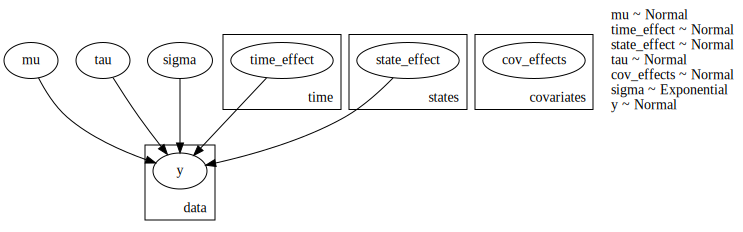

In [73]:
def cities_model_B(T_outcome, N_states, state_index, time_index,
                    intervention, covariates,
                y = None):
        # Intercept 
        mu = pyro.sample("mu", dist.Normal(0, 1))

        # time effects
        with pyro.plate("time", T_outcome):
                time_effect = pyro.sample("time_effect", dist.Normal(0, 1))

        # state latent confounders
        with pyro.plate("states", N_states):
                state_effect = pyro.sample("state_effect", dist.Normal(0, 1))
        
        #treatment effect
        tau = pyro.sample("tau", dist.Normal(0, 1))

        # covariate coefficients
        with pyro.plate("covariates", covariates.shape[1]):
                cov_effects = pyro.sample("cov_effects", dist.Normal(0, 1))

        # sd 
        sigma = pyro.sample("sigma", dist.Exponential(1))
        

        with pyro.plate("data", len(time_index)):
        
                print(unit_index)
                


                y_mean =(mu  + tau * intervention + 
                    time_effect[time_index] +
                    state_effect[state_index]
                     # + 
                    #torch.dot(covariates[unit_index], cov_effects)
                )

                print("ymean", y_mean.shape)
                print("mu", mu)
                print("tau", tau)
                print("intervention", intervention.shape)

                pyro.sample("y", dist.Normal(y_mean, sigma), obs = y)

        return  #y_mean, mu, beta, tau, alpha

pyro.render_model(cities_model_B, 
                  model_args=(T_outcome, N_states, state_index, time_index,
                               intervention, covariates), render_distributions=True)


## Vanilla model

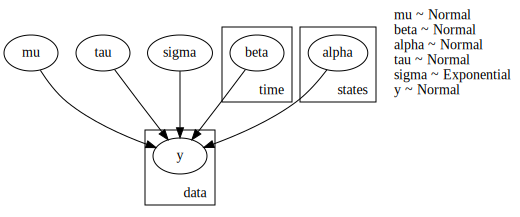

In [42]:
def cities_model_A(T_outcome, N_states, state_index, time_index, intervention,
                y = None):
        # Intercept 
        mu = pyro.sample("mu", dist.Normal(0, 1))

        # time effects
        with pyro.plate("time", T_outcome):
                beta = pyro.sample("beta", dist.Normal(0, 1))

        # state latent confounders
        with pyro.plate("states", N_states):
                alpha = pyro.sample("alpha", dist.Normal(0, 1))
        
        #treatment effect
        tau = pyro.sample("tau", dist.Normal(0, 1))

        # sd 
        sigma = pyro.sample("sigma", dist.Exponential(1))
        

        with pyro.plate("data", len(time_index)):
        
                y_mean = mu  + beta[time_index]  + alpha[state_index] + tau * intervention
                pyro.sample("y", dist.Normal(y_mean, sigma), obs = y)

        return  #y_mean, mu, beta, tau, alpha

pyro.render_model(cities_model_A, 
                  model_args=(T_outcome, N_states, state_index, time_index,
                               intervention), render_distributions=True)


/home/rafal/anaconda3/envs/chirho/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/rafal/anaconda3/envs/chirho/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/rafal/anaconda3/envs/chirho/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/rafal/anaconda3/envs/chirho/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future v

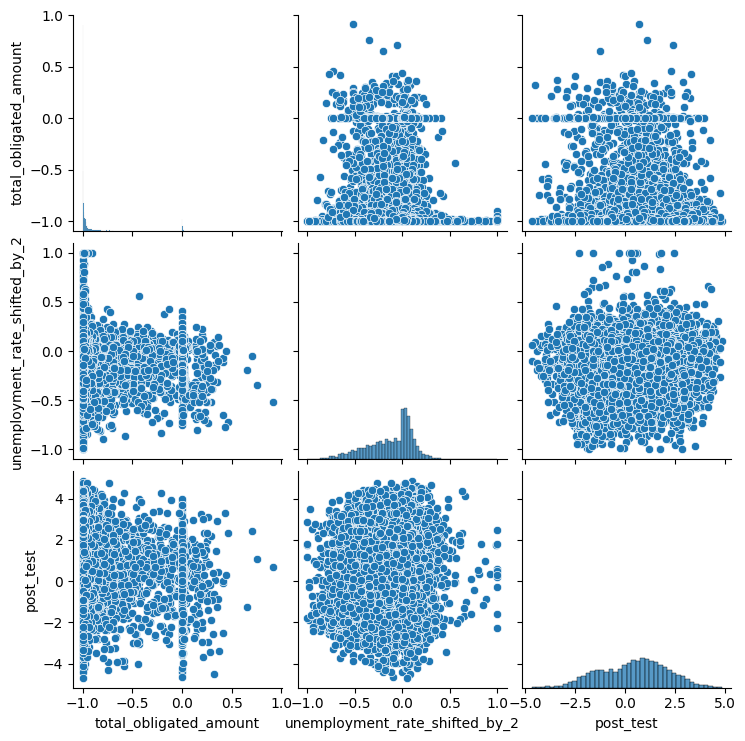

In [44]:
plot_predictive(cities_model_A, T_outcome = T_outcome, N_states = N_states, state_index = state_index,
                                time_index = time_index, intervention = intervention)

In [45]:
pyro.clear_param_store()
guide =  AutoNormal(cities_model_A)

# fast but much less informative
#AutoDelta(cities_model_A)

# this is painfully slow
#AutoMultivariateNormal(cities_model_A)

svi = SVI(
    model=cities_model_A,
    guide=guide,
    optim=Adam({"lr": 0.01}),
    loss=Trace_ELBO()  
)

#TODO add stop when losses sufficiently flatten 
losses = []
num_iterations = 1000
for step in range(num_iterations):
    # Compute the loss
    loss = svi.step(T_outcome, N_states, state_index, time_index, intervention, y)
    losses.append(loss)
    if step % 100 == 0:
        print('[iteration %04d] loss: %.4f' % (step + 1, loss / len(i_o_data)))


[iteration 0001] loss: 0.8767
[iteration 0101] loss: 0.3041
[iteration 0201] loss: -0.0483
[iteration 0301] loss: -0.1652
[iteration 0401] loss: -0.1752
[iteration 0501] loss: -0.1711
[iteration 0601] loss: -0.1812
[iteration 0701] loss: -0.1814
[iteration 0801] loss: -0.1814
[iteration 0901] loss: -0.1801


In [46]:
predictive = pyro.infer.Predictive(cities_model_A, guide=guide, num_samples=1000, parallel=False)
samples = predictive(T_outcome = T_outcome, N_states = N_states, state_index = state_index,
                                time_index = time_index, intervention = intervention)

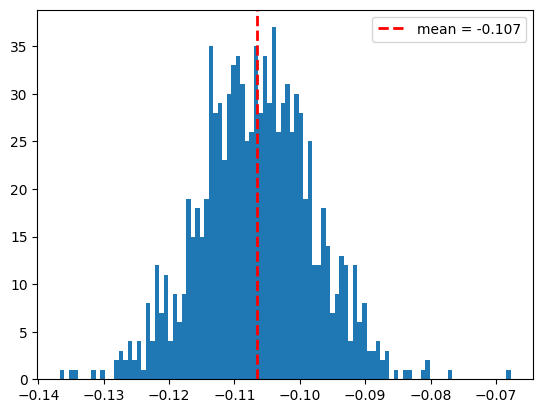

In [47]:
# this is a naive estimate

tau_samples = samples['tau'].detach().numpy()
plt.hist(tau_samples,bins = 100)
plt.axvline(x=tau_samples.mean(), color='red', linestyle='dashed', linewidth=2, label=f'mean = {tau_samples.mean():.3f}')
plt.legend()
plt.show()